# Plotting


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import simpy
import random
from scipy import stats
import warnings

def data_loader(name):
    """ Given a csv  file containg it returns the data as {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations} """
    df = pd.read_csv(name)
    df.set_index('Unnamed: 0', inplace= True)
    return df.to_dict()

In [43]:
class FiFoServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.Resource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

class SJFServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.PriorityResource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

def task(name, env, servers, processing_time, waiting_times, print_tasks):

    # A task arrives at the server
    start_time = env.now
    if print_tasks:
        print(f'Task {name} arriving at {start_time}')
    
    servers.final_arrival = start_time
    servers.N += 1
    servers.queue_length += 1

    # Request task to server
    with servers.server.request() as req:

        # Once there is availability at the server, initiate task
        yield req
        end_time = env.now
        servers.queue_length -= 1
  
        if print_tasks:
            print(f'Server starts processing {name} at {end_time}')

        yield env.timeout(processing_time)

        if print_tasks:
            print(f'Server done processing {name} at {env.now}')

        waiting_times.append(end_time - start_time)
        servers.processing_times.append(processing_time)


def get_confidence(data, p=0.95):
    """
    Calculate the mean and confidence interval of a dataset for a given confidence level.

    Parameters:
    - data (array-like): Input data.
    - p (float, optional): Confidence level (default is 0.95).

    Returns:
    tuple: A tuple containing the mean and the confidence interval.
    """

    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n - 1)
    sigma = np.std(data)
    confidence = (lamb * sigma / np.sqrt(n))
    return mean, confidence

In [44]:
def run_simulation(num_servers, mu, lambda_, N, scheduler, print_statistics, mode):
    env = simpy.Environment()

    # Use either First-in First-out or Shortest Job First scheduling
    if scheduler.lower() == 'fifo':
        servers = FiFoServers(env, mu, num_servers)
    elif scheduler.lower() == 'sjf':
        servers = SJFServers(env, mu, num_servers)

    waiting_times = []

    # Generate tasks
    
    if mode == 'deter':
        env.process(task_generator_deter(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'long tail':
        env.process(task_generator_long_tail(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'Markov':
        env.process(task_generator(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    
    # Calculate statistics on waiting times
    waiting_times_array = np.array(waiting_times)
    confidence_level = 0.95

    # Calculate confidence interval of waiting time
    mean_waitingtime, confidence_waitingtime = get_confidence(waiting_times_array, confidence_level)

    # Calculate statistics on processing times
    processing_times_array = np.array(servers.processing_times)

    # Calculate confidence interval of processing rate
    mean, confidence = get_confidence(processing_times_array, confidence_level)

    if print_statistics:

        std_waiting_time = np.std(waiting_times_array)
        confidence_interval = (mean_waitingtime - confidence_waitingtime, mean_waitingtime + confidence_waitingtime)

        print(f"{num_servers} server(s):")
        print(f"Average Waiting Time: {mean_waitingtime}")
        print(f"Standard Deviation of Waiting Time: {std_waiting_time}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")
        
        processing_rates_array = 1 / processing_times_array[processing_times_array > 0]
        std_processing_rate = np.std(processing_rates_array)
        confidence_interval = (1 / (mean + confidence), 1 / (mean - confidence))

        print(f"Average Processing Rate of server: {1 / mean}")
        print(f"Standard deviation of Processing Rate {std_processing_rate}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")

        # Print statistics on arrivals
        print(f"Time of final arrival: {servers.final_arrival}")
        print(f"Number of arrivals: {servers.N}")
        print(f"Average arrivals per timestep: {servers.N / servers.final_arrival}\n\n")

    return mean_waitingtime, confidence_waitingtime


In [45]:
def generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n=1):
    """Generates data for the average waiting times with different servers and different system loads."""
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}

    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = []

            # Run simulation multiple times
            for _ in range(n):
                mean_waitingtime, confidence_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, False, mode)
                if n == 1:
                    confidences.append(confidence_waitingtime)
                    waitingtimes.append(mean_waitingtime)
                else:
                    waiting_times_for_simulations.append(mean_waitingtime)

            if n > 1:
                # Calculate mean and confidence interval using the get_confidence function
                mean, confidence = get_confidence(waiting_times_for_simulations)
                waitingtimes.append(mean)
                confidences.append(confidence)

        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences}

    return data

In [47]:
def task_generator(env, servers, N, lambda_, waiting_times, print_tasks=False):

    # Generate N tasks
    for i in range(N):
        
        # Calculate time at server by Poisson process, not sure if necessary
        processing_time = random.expovariate(servers.mu)

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_long_tail(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    # Generate 0.75#N tasks with a processing time of 5*mu
    for i in range(N):

        if i >= N*0.75:
            processing_time = random.expovariate(servers.mu)
        else:
            processing_time = random.expovariate(0.4*servers.mu)
        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_deter(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    for i in range(N):
        processing_time = 1/servers.mu

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

## Finding N and n

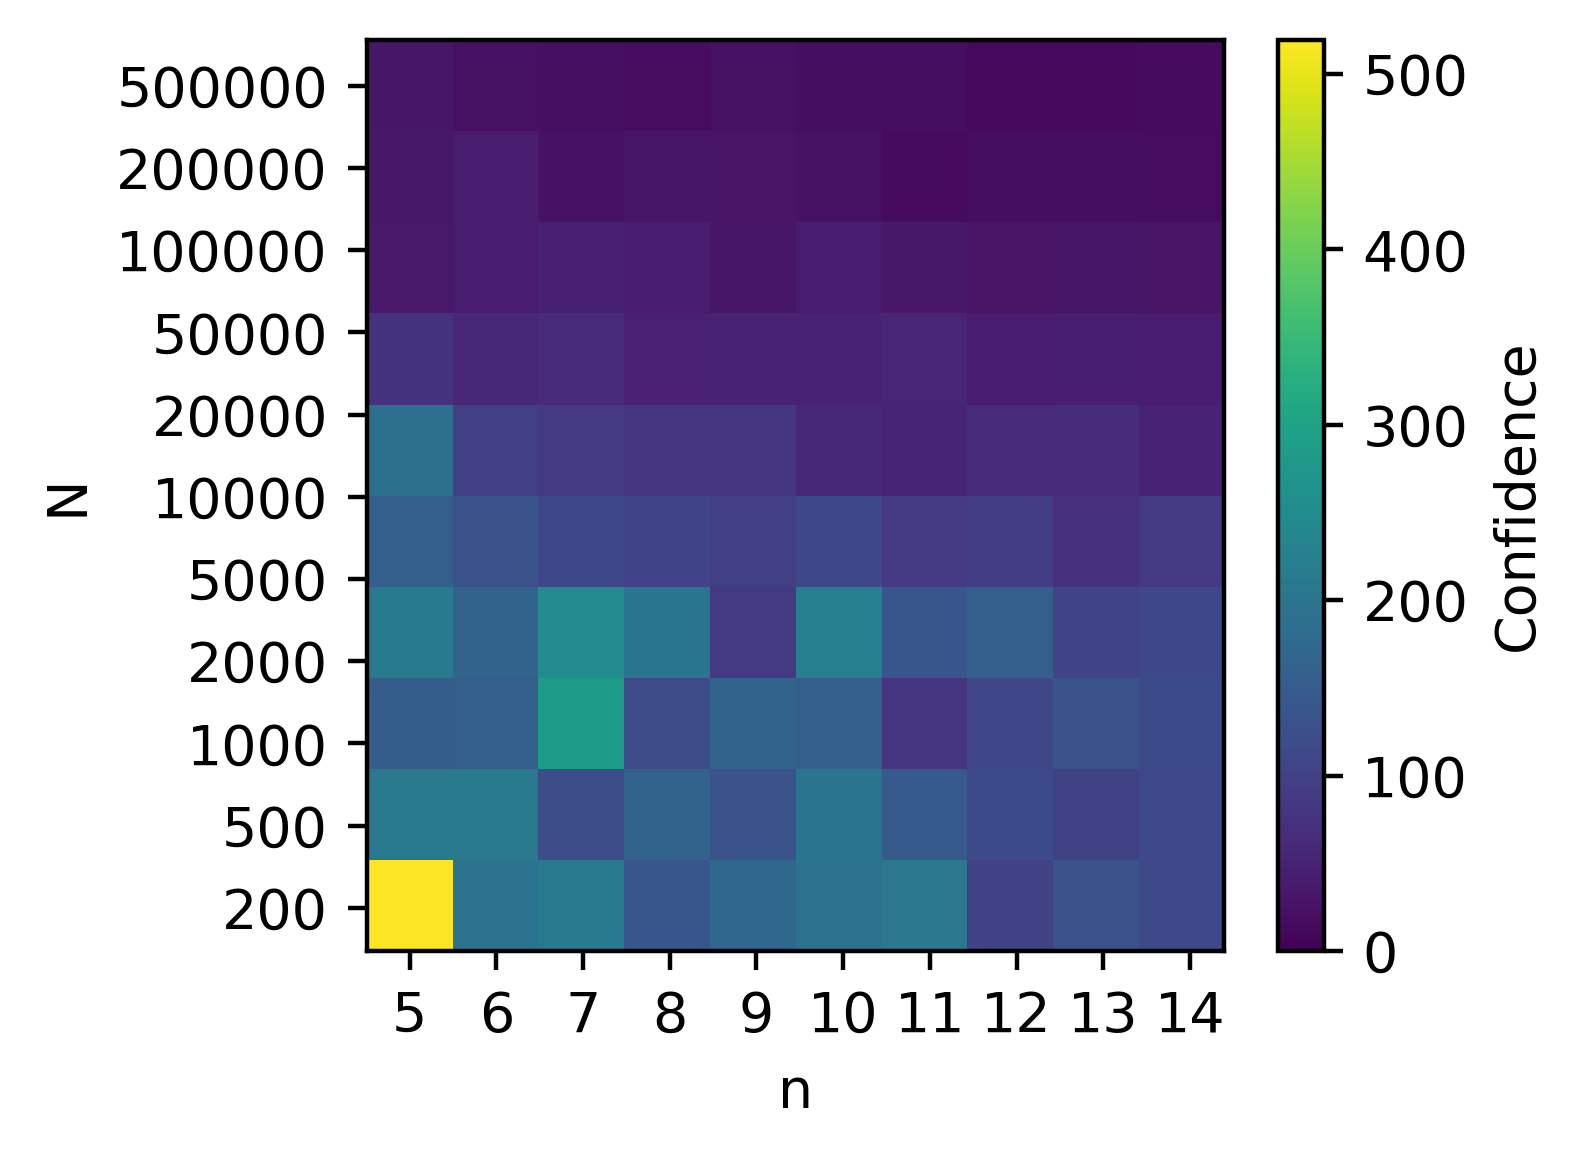

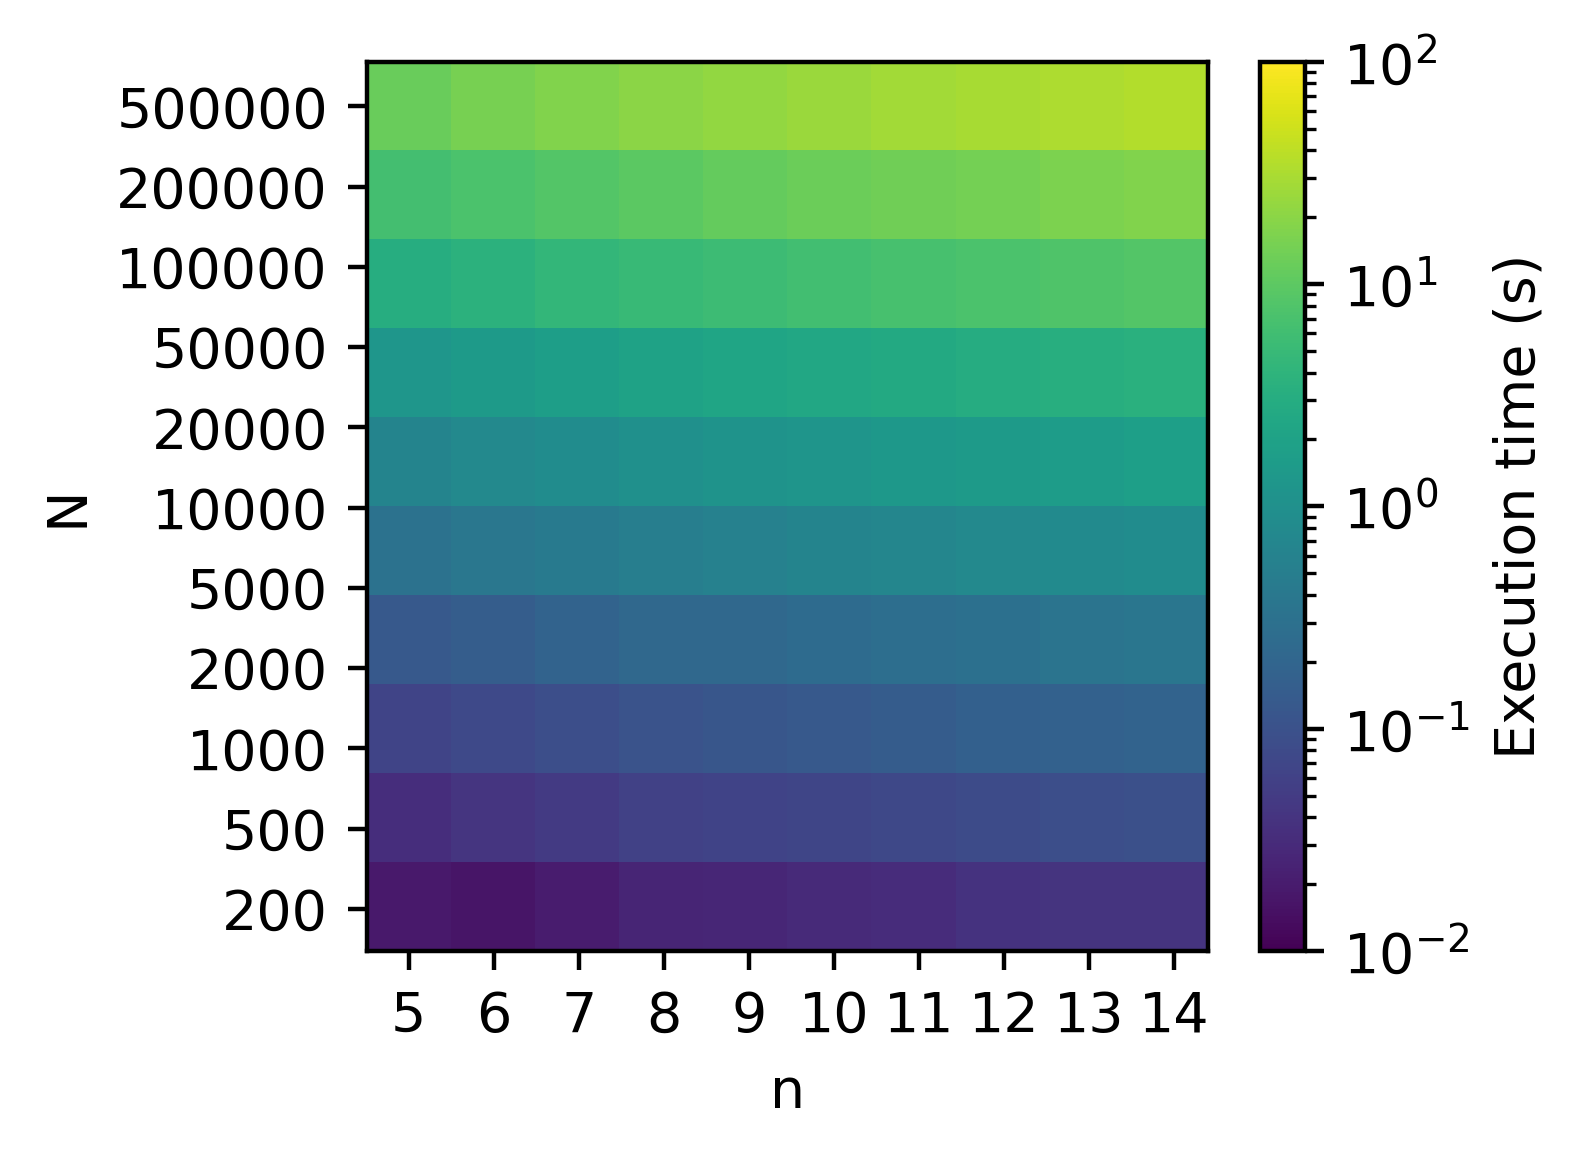

In [36]:
heatmap_data = np.loadtxt('heatmap_data.txt')
plt.figure(figsize=(4,3),dpi=400)
plt.imshow(heatmap_data, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', vmin=0)

colorbar = plt.colorbar(label=f'Confidence')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(25_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_waitingime.png')
plt.show()

data_times = np.loadtxt('heatmap_times.txt')
plt.figure(figsize=(4,3),dpi=400)
plt.imshow(data_times, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', norm=LogNorm(0.01, 100))

colorbar = plt.colorbar(label=f'Execution time (s)')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(25_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_time.png')
plt.show()

## Question 2

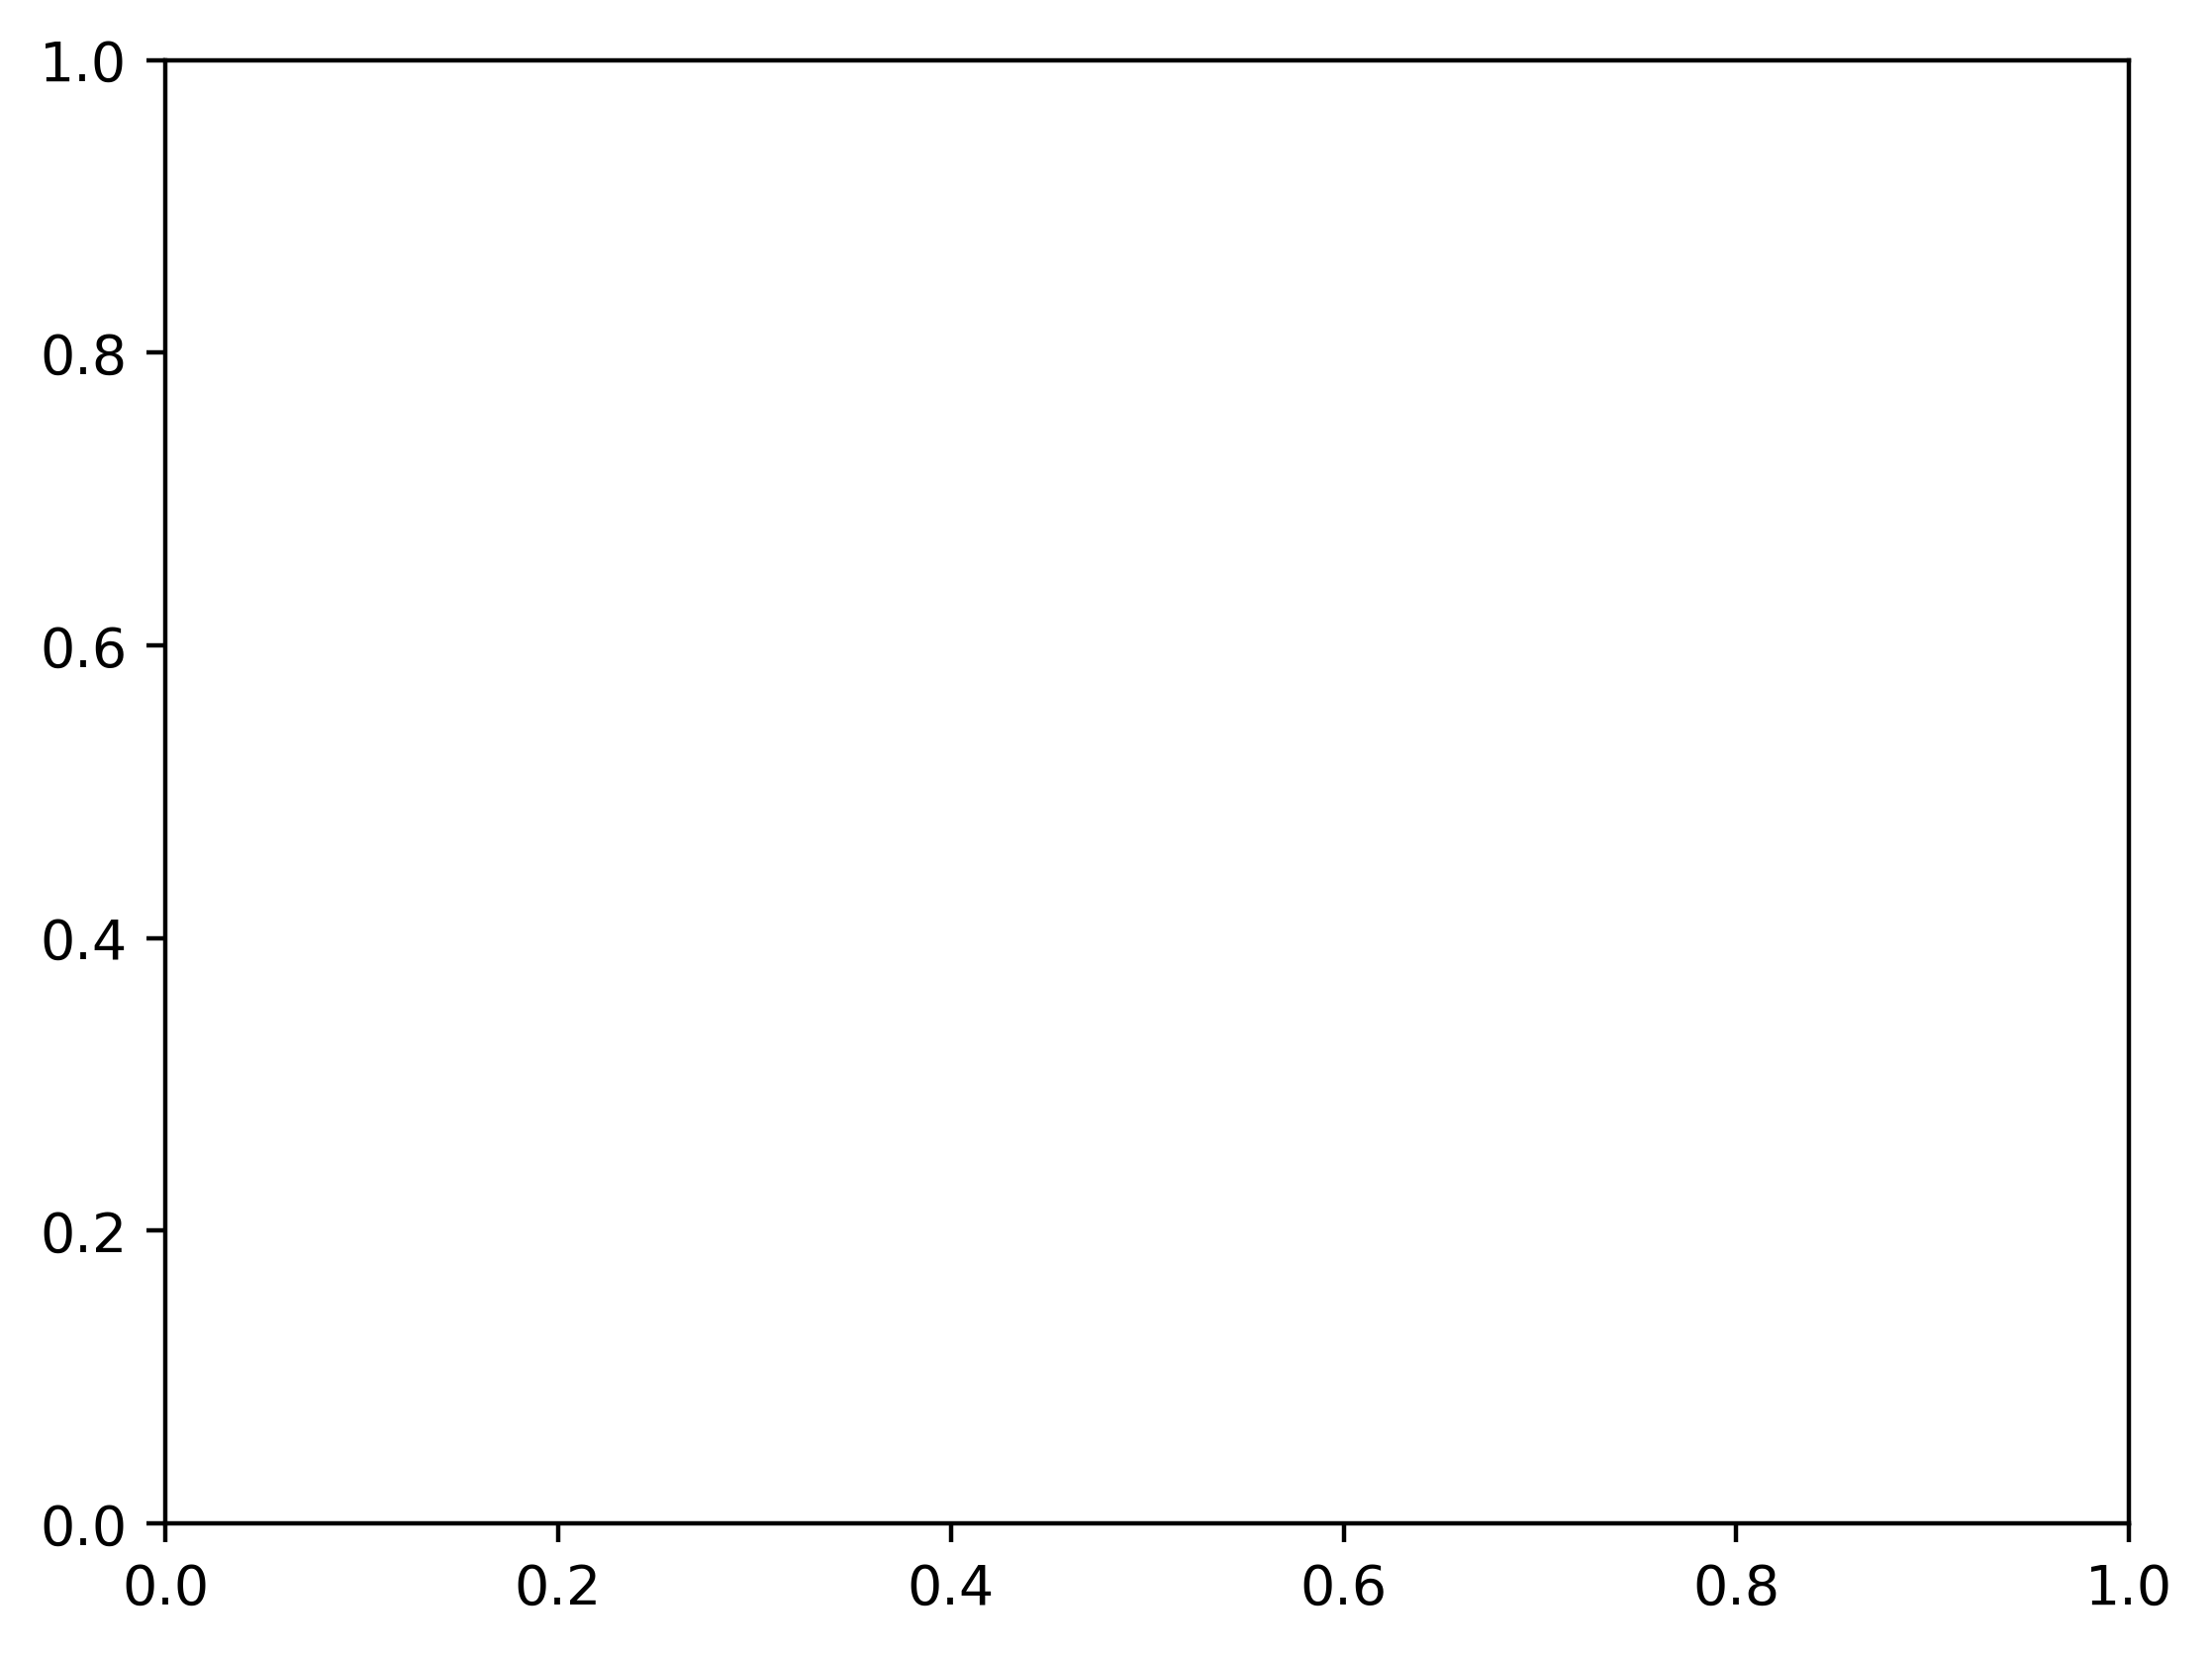

In [48]:
# n = 10, N= 20000
n = 10
N = 20000
num_servers_list = [1,2,4]

# Run M/M/c
lambda_ = 0.015
scheduler = 'fifo'
mode = 'Markov'
print_statistics = False
rho_min, rho_max = 0.7, 0.95
rhos_step = 0.01
rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

#fig, axs = plt.subplots(dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)


{1: {'x': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94]), 'waitingtimes': [109.89409269991222, 117.50379664032839, 125.20568772526379, 132.70733850199525, 145.92770693915162, 150.84861739226739, 158.1364063746233, 168.30547625329683, 177.06726447136032, 189.56071613802445, 216.25764340002607, 225.665553798371, 261.06657850856243, 279.3714951497984, 294.8603503191654, 320.622071017004, 356.3964061496464, 402.24966909389025, 457.74249675498595, 467.3702033754138, 536.1743644966402, 574.8823047315934, 664.8499227506843, 856.7610416916257, 864.642010108421], 'confidences': [3.5114894997821886, 2.573973026944612, 5.005813577888844, 4.149597889693112, 5.5646990701648935, 5.804775049754957, 5.2799243568724705, 10.388294746832948, 7.841889223402209, 8.886341073532797, 8.580323332784248, 9.813653904304747, 22.819622578341125, 14.564785584544804, 25.6308814156627, 24.66591

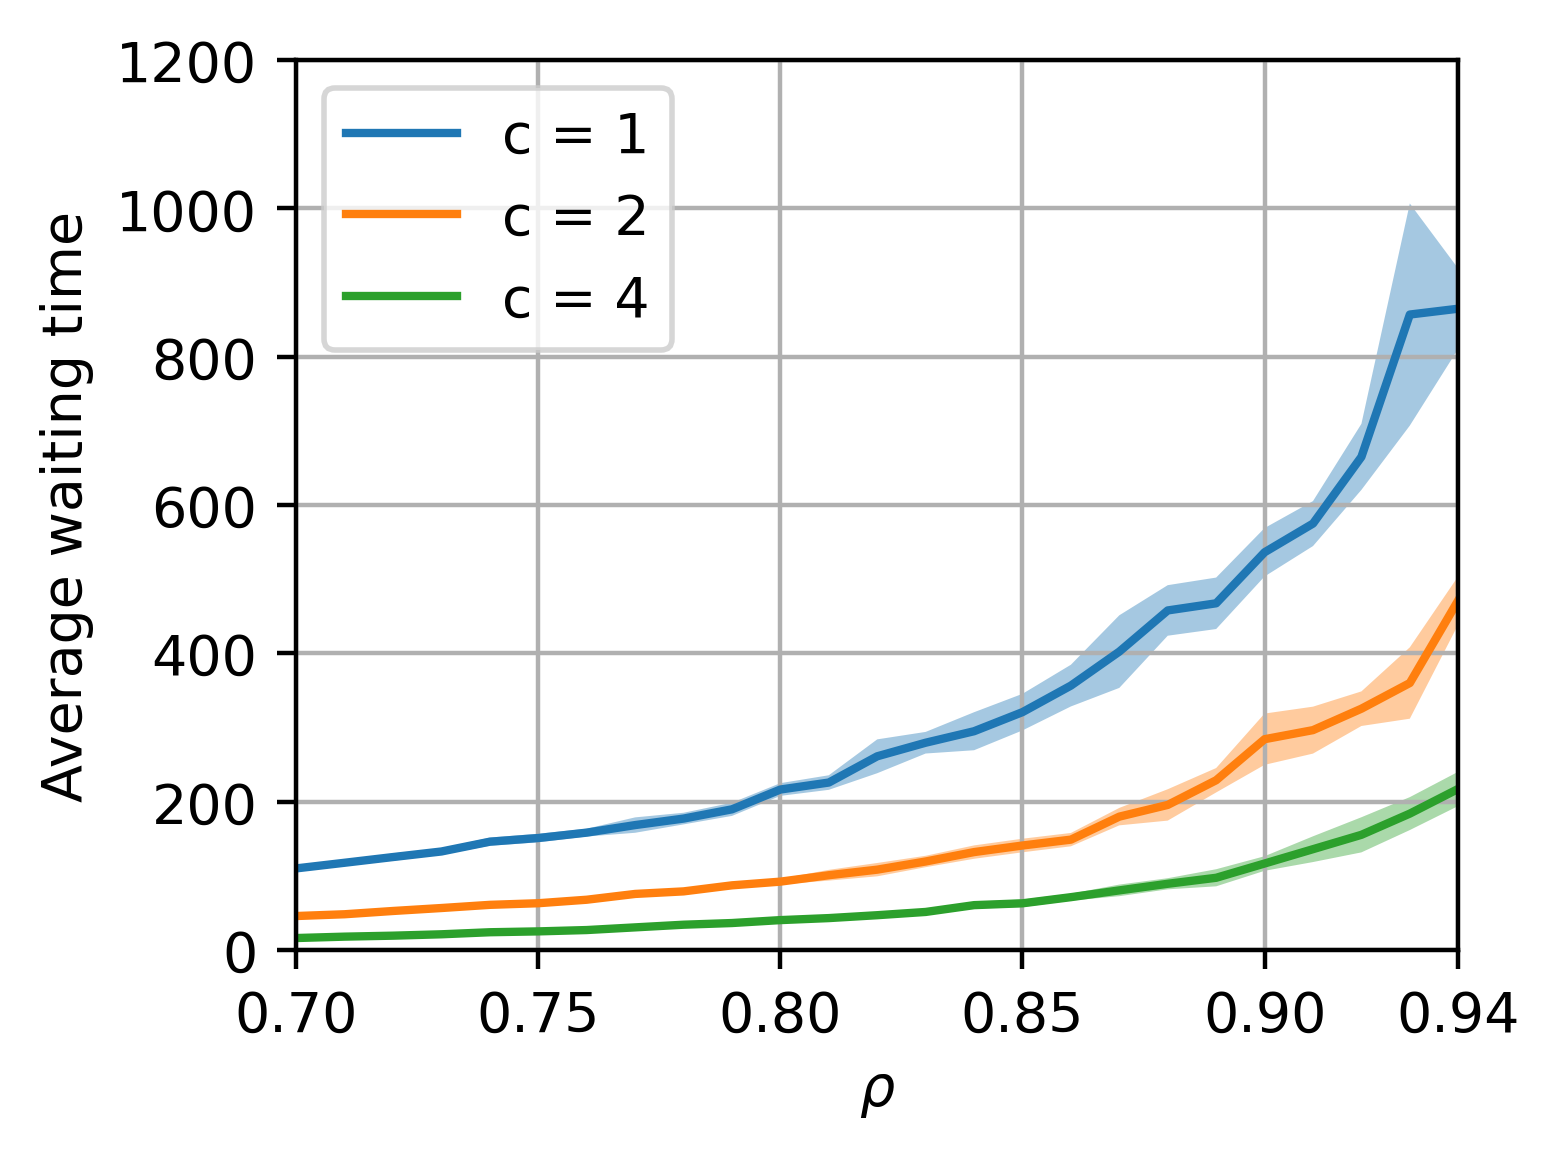

In [78]:
# Plot
print(data)

plt.figure(figsize=(4,3),dpi=400)

for num_servers, values in data.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.show()
plt.savefig('Q2_MMc_FIFO.png')

In [69]:
# n = 10, N= 20000, NOW WITH SJF
n = 10
N = 20000
num_servers_list = [1,2,4]

# Run M/M/c
lambda_ = 0.015
scheduler = 'sjf'
mode = 'Markov'
print_statistics = False
rho_min, rho_max = 0.7, 0.95
rhos_step = 0.01
rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

#fig, axs = plt.subplots(dpi=400)
data_sjf = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

{1: {'x': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94]), 'waitingtimes': [106.48840172355888, 115.30119657880994, 124.36978357126932, 132.7067087649877, 138.09225288199457, 156.68405766599082, 157.239131176309, 167.76601150839988, 190.55162996910798, 203.73596743429948, 206.02102282469815, 239.2879935772563, 249.11456356035882, 265.211535429889, 282.23925596523316, 326.2417324398567, 333.1015453240146, 372.2068638388123, 456.8855546074066, 471.4837409774521, 535.4628013352491, 559.2837680831246, 665.676235991115, 856.5593891100941, 928.7509134904058], 'confidences': [3.748601906043358, 4.254522785491869, 5.051776839318759, 7.691868237561787, 7.352086109089203, 8.027994317417912, 4.466423939055225, 4.59898716847141, 10.454277018309076, 17.573208298681664, 10.27190325427412, 12.380068526455844, 11.322077012134333, 11.81825368840816, 15.436744835438597, 18.88292763

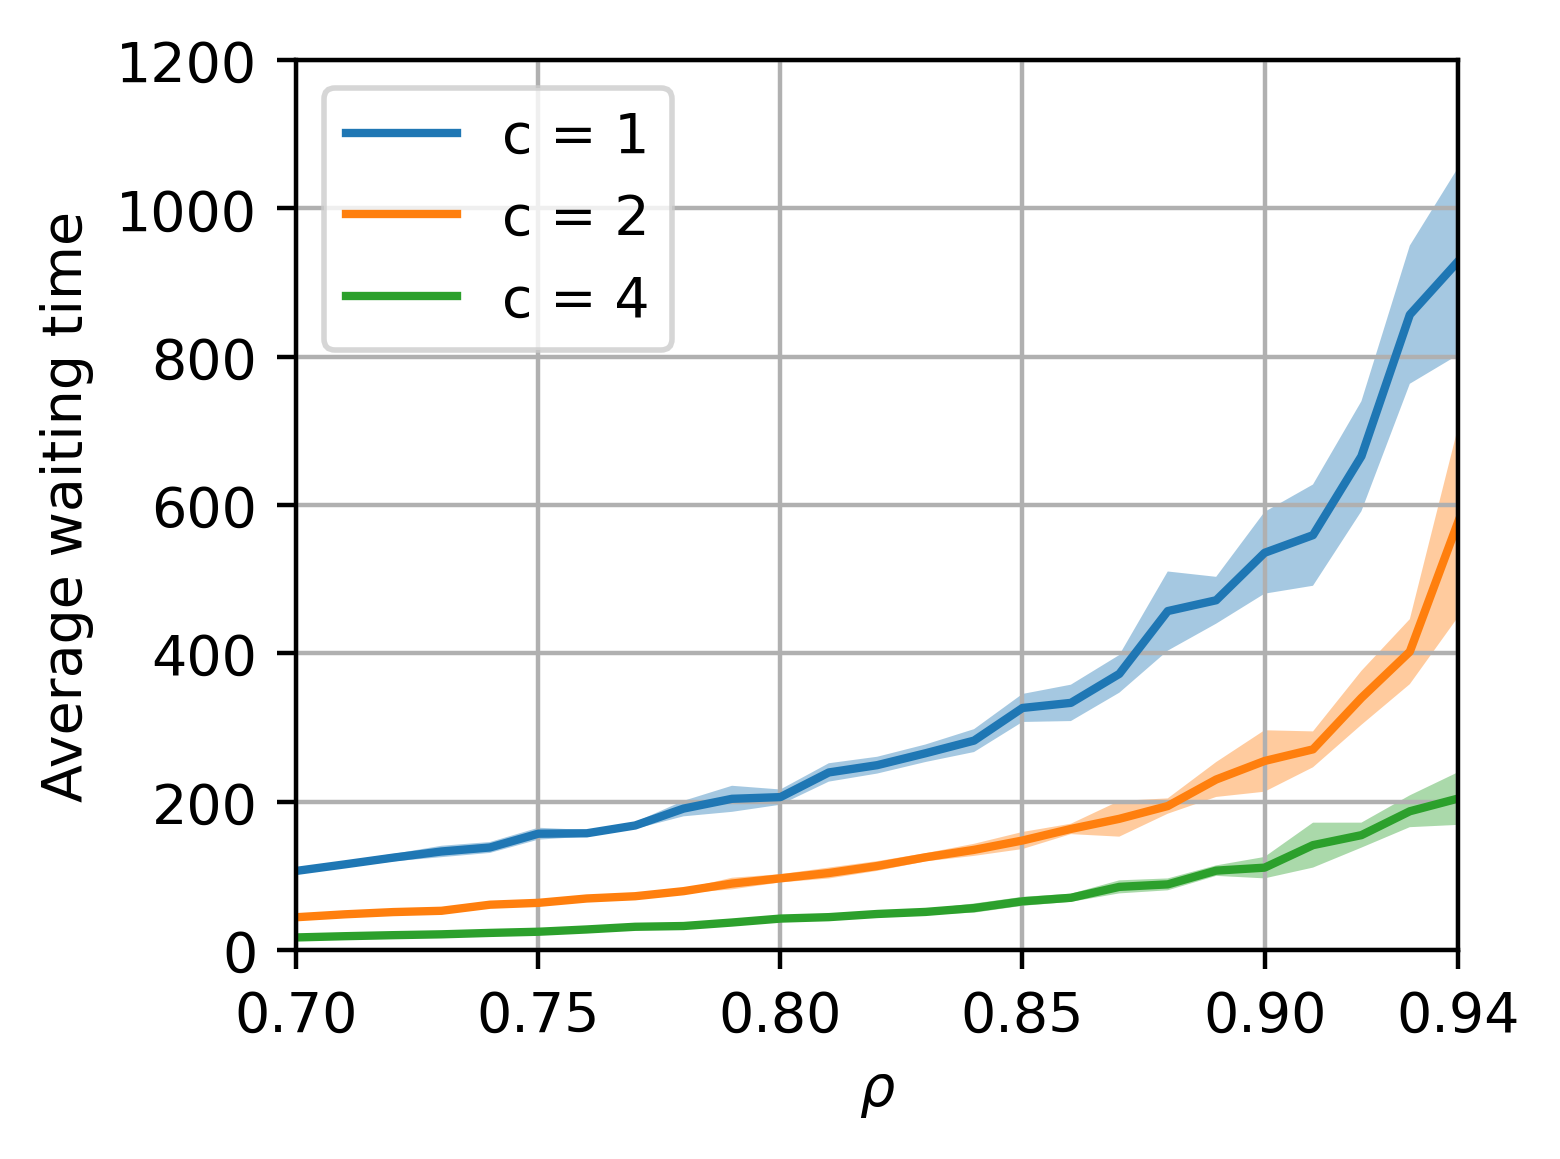

In [79]:
# Plot 2
print(data_sjf)

plt.figure(figsize=(4,3),dpi=400)

for num_servers, values in data_sjf.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('Shortest Job First')
plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Q2_MMc_SJF.png')
plt.show()

## Question 3


In [ ]:
# Same square plot but for M/M/c with SJF

## Question 4

In [60]:
# Read files
import csv

with open("Q4_test-1.txt") as f:
    reader = csv.reader(f)
    headers = next(reader)
    lines = list(reader)

Q4_test = dict(zip(headers, zip(*lines)))
print(Q4_test)

#Q4_test = data_loader("Q4_test-1.txt")

#print(Q4_test)
# Data_Q4_from_0_1
#long = np.loadtxt("Q4_test.txt")
#deter = np.loadtxt("Q4_test_deter.txt")
#markov = np.loadtxt("Q4_test_markov.txt")

plt.figure(figsize=(4,3),dpi=400)

for num_servers, values in Q4_test.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.show()
plt.savefig('Q4.png')


print('Done')

{"{1: {'x': np.array([0.01": ('         0.12', '         0.23', '         0.34', '         0.45', '         0.56', '         0.67', '         0.78', '         0.89', "  'waitingtimes': [0.015130290010603575", '   0.061224688442562396', '   0.1481978468693071', '   0.26750685612658204', '   0.40369147661996996', '   0.6013501621041398', '   0.8145563481187296', '   1.1068426162735197', '   1.470782328010922', '   1.7205843783838122', '   2.252111188881177', '   2.550916340222359', '   3.1078877791917408', '   3.7292443935229365', '   4.389295270755115', '   5.078047854529327', '   5.671999606546486', '   6.431860568200824', '   7.6017550667829275', '   8.105484425902711', '   9.640181473084793', '   10.654760813026178', '   12.05823074697708', '   13.258594356821707', '   14.3396812848455', '   16.275762445021957', '   17.914171530960395', '   20.11377258454947', '   21.1672260658512', '   24.335560489951877', '   26.16256355334056', '   28.181036733237185', '   30.946395656536787', '  

TypeError: tuple indices must be integers or slices, not str

<Figure size 1600x1200 with 0 Axes>

{'1': {'x': '[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]', 'waitingtimes': '[0.0, 0.0036059881649750554, 0.016996963457264105, 0.04213758094049376, 0.08750649350553748, 0.16776975518707332, 0.30179382605693744, 0.5334379455159559, 1.0502854236741144, 2.3138492685645735]', 'confidences': '[0.0, 0.00015253578255629215, 0.0005510723375159515, 0.0011993316664371562, 0.002444969967882251, 0.00572004184573428, 0.01114407244705147, 0.02341830813884569, 0.07959839197164806, 0.20153820923668322]', 'n_simulations': '[51, 51, 51, 51, 51, 51, 51, 51, 51, 51]'}, '2': {'x': '[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]', 'waitingtimes': '[0.0, 0.0004188486444644748, 0.0031098726498070255, 0.010899043380974693, 0.026689764510597305, 0.056973839829617796, 0.1170750601466246, 0.22643187265836232, 0.45525984709368783, 1.1815786196716112]', 'confidences': '[0.0, 3.1834798114819494e-05, 0.00019375885424198028, 0.00048200422979362734, 0.0012688868412012093, 0.0021630946178704796, 0.0050219975242205075, 0.011194

ValueError: Unrecognized character [ in format string

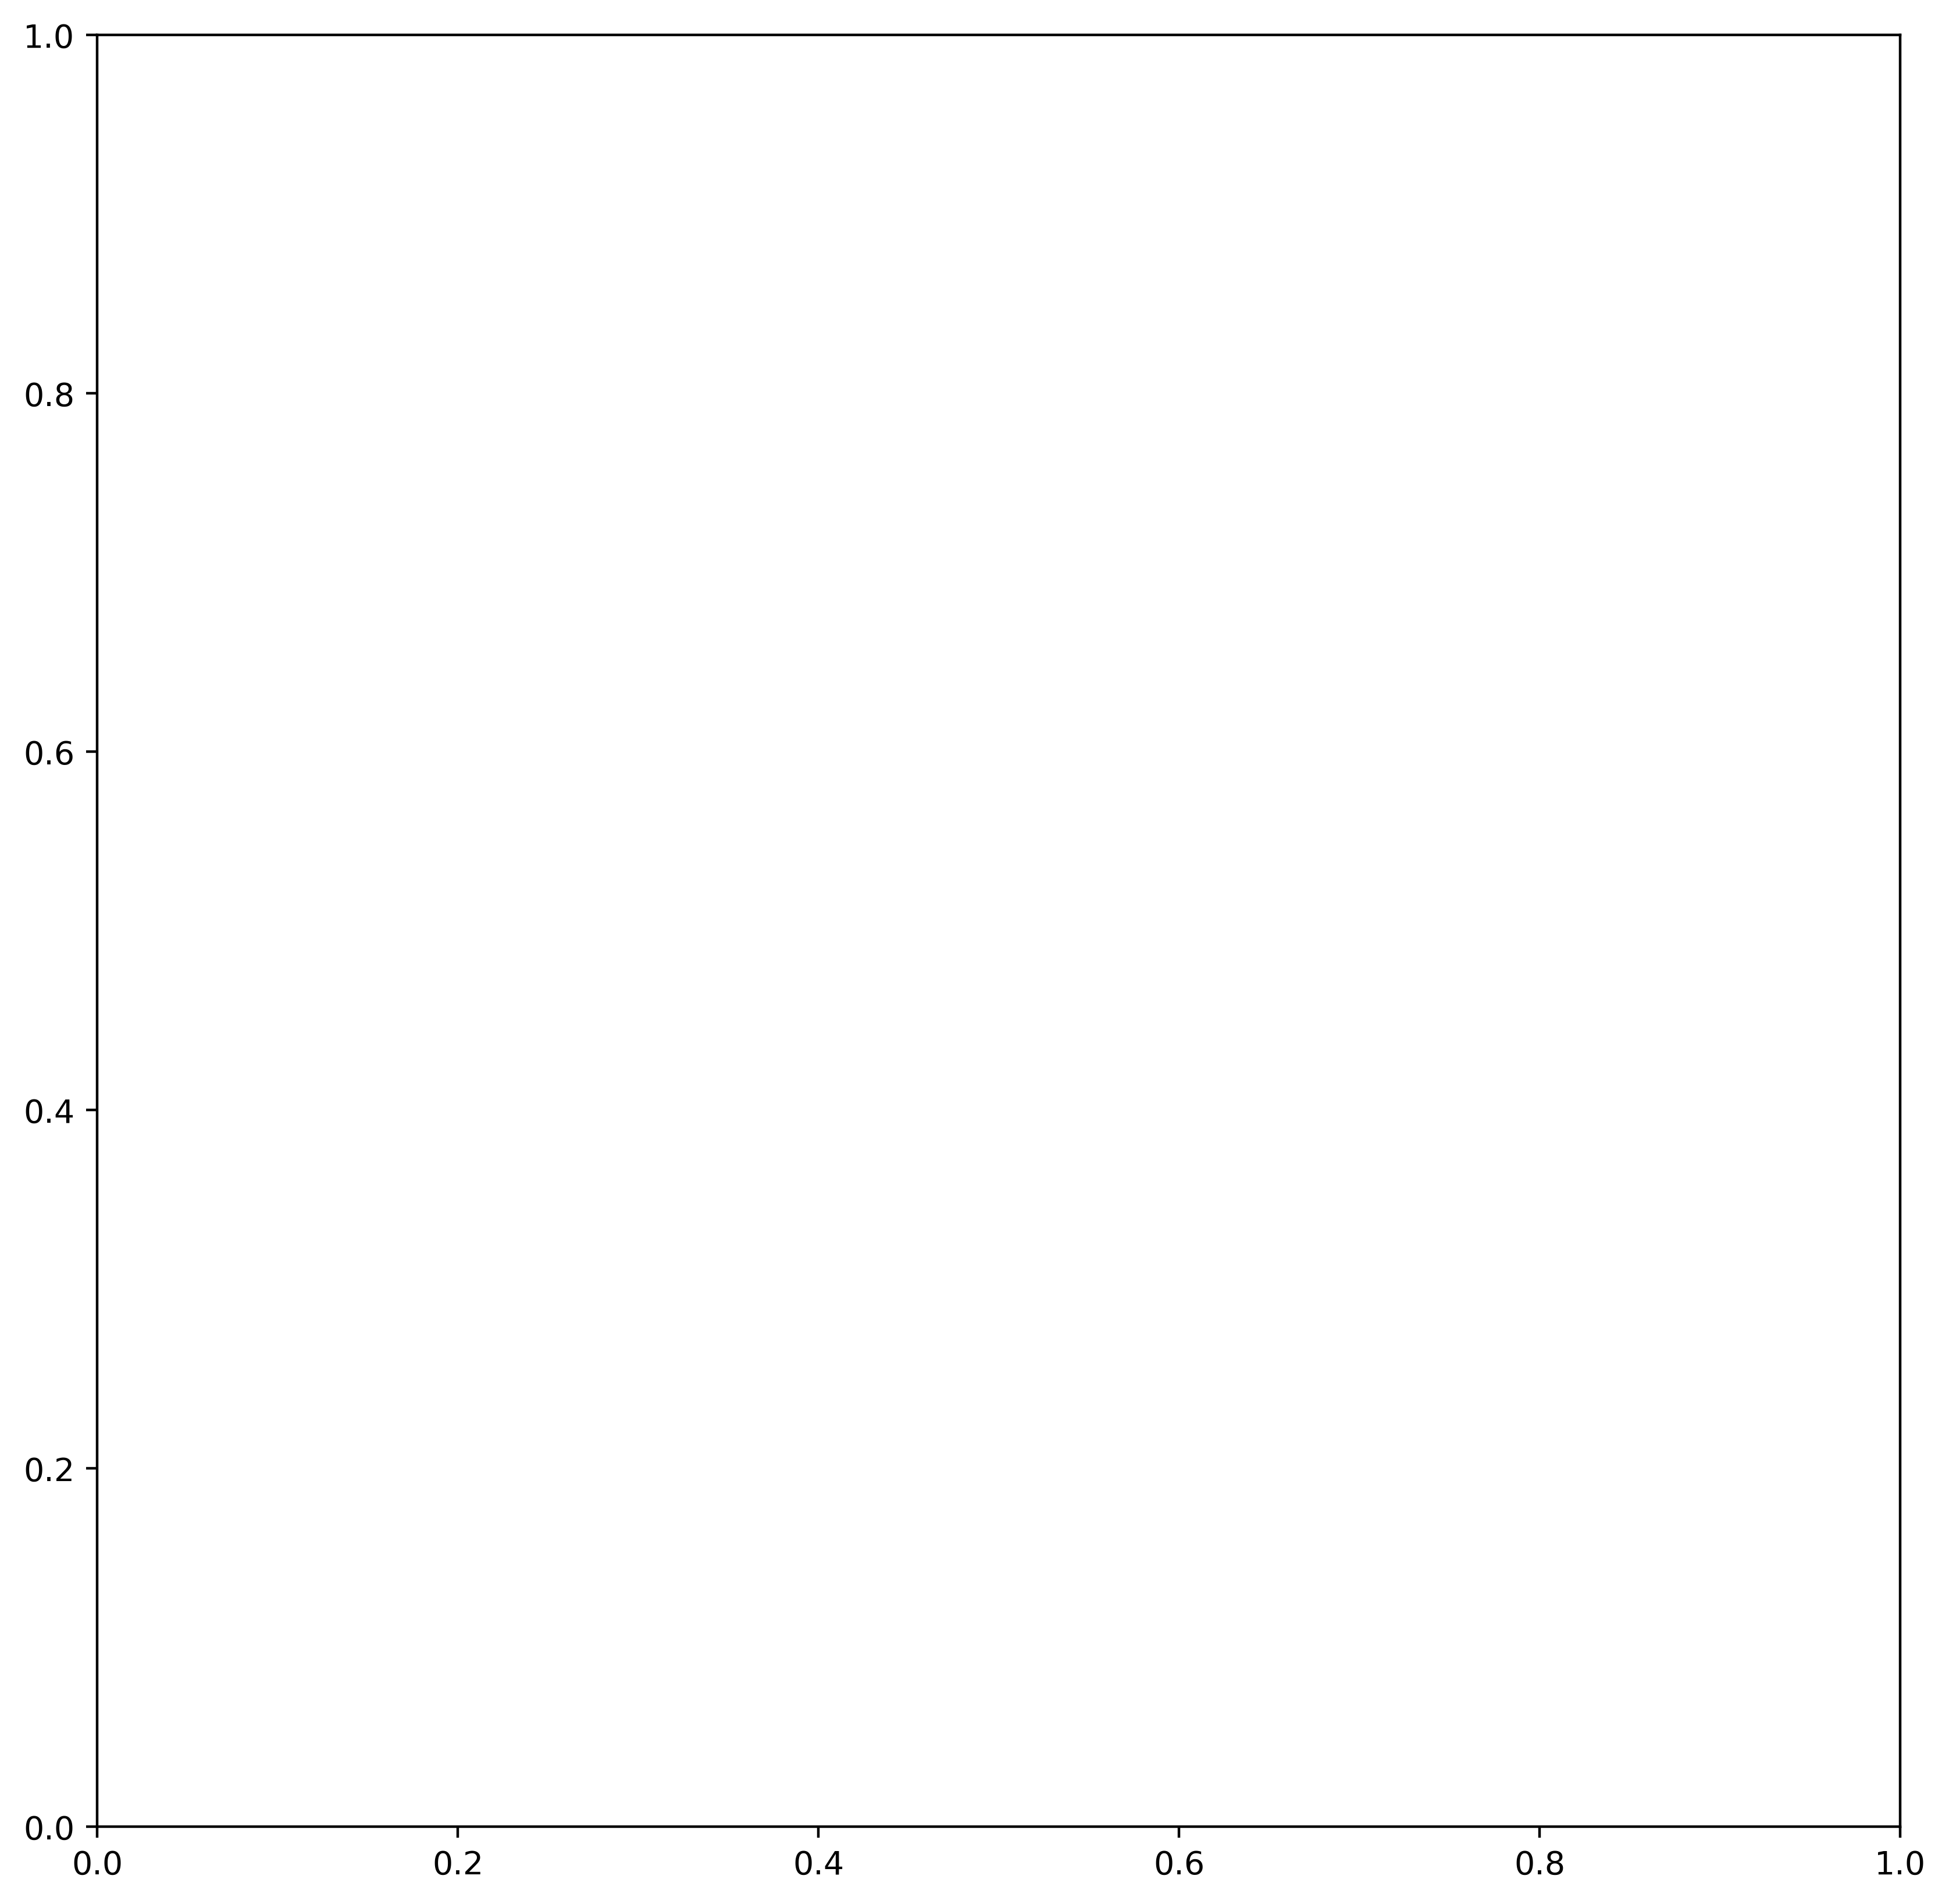

In [33]:
# Plot deter,long,markov

#print(deter['1']['x'])
#waitingtimes
#confidences
#n_simulations


def plot_waitingtimes(data, axs):
    """Plots the average waiting times with different servers and different system loads."""
    
    for num_servers, values in data.items():
        x = values['x']
        waitingtimes = values['waitingtimes']
        confidence_waitingtime = np.array(values['confidences'])

        print(x)
        print(waitingtimes)

        axs.plot(x, waitingtimes)   #, label=f'Number of servers = {num_servers}')
        
        #axs.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

    axs.set_xlabel("System load")
    axs.set_ylabel("Average waiting time")
    axs.legend()


fig, axs = plt.subplots(dpi=400, figsize = (10,10))
data = deter

print(data)
plot_waitingtimes(data, axs)

In [ ]:
# Save